In [1]:
import os
import sys
import mne
import matplotlib as plt
import sleepeegpy
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import yasa

import mne
import numpy as np
import pooch
from sleepeegpy.pipeline import (
    CleaningPipe,
    ICAPipe,
    SpectralPipe,
    SpindlesPipe,
    SlowWavesPipe,
    RapidEyeMovementsPipe,
)
from sleepeegpy.dashboard import create_dashboard

from os import makedirs

# Load EEG file (modify the filename)
raw = mne.io.read_raw_edf("2025-02-18_23-51-08_1a6055f0_27_electrodes.edf", preload=True)

# # Apply bandpass and notch filtering
raw.filter(l_freq=0.75, h_freq=40, picks="eeg")  # Bandpass: 0.75-40 Hz
raw.notch_filter(freqs=50, picks="eeg")  # Remove 50Hz powerline noise

# # Detect bad segments automatically
epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
stds = np.std(epochs.get_data(), axis=(1, 2))
threshold = np.mean(stds) + 2 * np.std(stds)
bad_epochs = np.where(stds > threshold)[0]

# # Annotate detected bad segments
for epoch_idx in bad_epochs:
    onset = epochs.events[epoch_idx, 0] / raw.info['sfreq']
    #buffer_time = 1.5  # Adjust as needed
    #onset_corrected = onset - buffer_time
    raw.annotations.append(onset, 3, "BAD")



Extracting EDF parameters from /Users/patriciaalmeida/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/DTU/Spring 2025/Special course/sleepeeg/2025-02-18_23-51-08_1a6055f0_27_electrodes.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8839679  =      0.000 ... 34529.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.75 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.75
- Lower transition bandwidth: 0.75 Hz (-6 dB cutoff frequency: 0.38 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1127 samples (4.402 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.4s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Not setting metadata
17265 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17265 events and 512 original time points ...
0 bad epochs dropped


In [ ]:
fig = raw.plot()

In [2]:
print(raw.info)
print(raw.annotations.description)  # The names of the annotations
print(raw.annotations.onset)        # The time (in seconds) when they occur
print(raw.annotations.duration) 

<Info | 8 non-empty values
 bads: []
 ch_names: FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, TP7, ...
 chs: 30 EEG
 custom_ref_applied: False
 highpass: 0.8 Hz
 lowpass: 40.0 Hz
 meas_date: 2025-02-18 23:51:08 UTC
 nchan: 30
 projs: []
 sfreq: 256.0 Hz
 subject_info: 3 items (dict)
>
['REC_STARTED ' 'Missing 1 samples / 0,00 seconds'
 'Missing 1 samples / 0,00 seconds' ... 'BAD' 'BAD' 'REC_HALTED ']
[8.59000000e-02 2.22556000e+02 2.48941000e+02 ... 3.41680000e+04
 3.41700000e+04 3.44691649e+04]
[0. 0. 0. ... 3. 3. 0.]


In [3]:
output_dir = "output_folder"  # Output path and name can be changed here
input_dir = "input_files"  # input files dir can be changed here
makedirs(input_dir, exist_ok=True)
makedirs(output_dir, exist_ok=True)

subject_code = "Sub 02" # The subject code that will appear in the dashboard
bad_channels = "bad_channels.txt"
annotations = "annotations.txt"
hypnogram_filename = "staging.txt"
hypno_freq = 1  # If required, change the Hypnogram's sampling frequency (Visbrain's hypnograms default to 1)
hypno_selection = "automatically"
annotations_selection = "from-file"
bad_channels_selection = "automatically"

if hypno_selection == "automatically":
    hypnogram_path = "predict"
    #### If you selected automatic hypnogram, select prediction arguments. ####
    hypno_predict_arguments = {
        "eeg_name": "C4", #(C4)
        "eog_name": None, #(EOG1)
        "emg_name": None,
        "ref_name" : "Cz",
    }
else:
    hypno_predict_arguments = None

n_components = 25 # initial was 30
picked_channel = "Pz"  # (Pz)
loc_chname = "R1"  # (EOG1)
roc_chname = "R2"  # (EOG2)

#path_to_eeg = os.path.join(input_dir, eeg_file)
if hypno_selection == "from-file":
    hypnogram_path = os.path.join(input_dir, hypnogram_filename)
bad_channels = (
    None if bad_channels_selection == "automatically" else os.path.join(input_dir, bad_channels))
annotations = ( None if annotations_selection == "automatically" else os.path.join(input_dir, annotations))

## 1. Cleaning

In [11]:
path_to_eeg = os.path.join(input_dir, "2025-02-18_23-51-08_1a6055f0_27_electrodes.edf")
pipe = CleaningPipe(path_to_eeg=path_to_eeg, output_dir=output_dir)
# start_time = 18000
# pipe.mne_raw.crop(tmin=start_time)

# Apply bandpass and notch filtering
pipe.resample(sfreq=256, n_jobs=-1, verbose=False)
pipe.filter(l_freq=0.75, h_freq=40, n_jobs=-1,) # Bandpass
pipe.notch(freqs=50, n_jobs=-1,) #Notch

Extracting EDF parameters from /Users/patriciaalmeida/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/DTU/Spring 2025/Special course/sleepeeg/input_files/2025-02-18_23-51-08_1a6055f0_27_electrodes.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8839679  =      0.000 ... 34529.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.75 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.75
- Lower transition bandwidth: 0.75 Hz (-6 dB cutoff frequency: 0.38 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1127 samples (4.402 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.3s finished


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.2s finished


In [12]:
# Detect bad segments automatically
epochs = mne.make_fixed_length_epochs(pipe.mne_raw, duration=2)
stds = np.std(epochs.get_data(), axis=(1, 2))
threshold = np.mean(stds) + 2 * np.std(stds)
bad_epochs = np.where(stds > threshold)[0]

# # Annotate detected bad segments
for epoch_idx in bad_epochs:
    onset = epochs.events[epoch_idx, 0] / pipe.mne_raw.info['sfreq']
    pipe.mne_raw.annotations.append(onset, 2, "BAD")

Not setting metadata
17265 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17265 events and 512 original time points ...
0 bad epochs dropped


In [6]:
fig = pipe.mne_raw.plot()
print(pipe.mne_raw.annotations)

Using qt as 2D backend.
Using pyopengl with version 3.1.9
<Annotations | 992 segments: BAD (292), Missing 1 samples / 0,00 seconds ...>


Channels marked as bad:
none


In [13]:
# Load a standard 10-20 montage
montage = mne.channels.make_standard_montage("standard_1020")

# Get only the channels that exist in the montage
valid_channels = [ch for ch in pipe.mne_raw.ch_names if ch in montage.ch_names]
pipe.mne_raw.pick_channels(valid_channels)

# Apply montage
pipe.mne_raw.set_montage(montage)

# Now run bad channel detection
#bad_channels = pipe.auto_detect_bad_channels()

pipe.mne_raw.info

pipe.set_eeg_reference(ref_channels="average", projection=True)

if bad_channels_selection == "manually":
    pipe.plot(save_bad_channels=True)
elif bad_channels_selection == "automatically":
    bad_channels = pipe.auto_detect_bad_channels()

pipe.read_bad_channels(path=None if bad_channels_selection == "Manually" else bad_channels)

pipe.interpolate_bads(reset_bads=True)

if annotations_selection == "manually":
    pipe.plot(butterfly=True, save_annotations=True, overwrite=True)
    pipe.read_annotations()
elif annotations_selection == "from-file":
    pipe.read_annotations(path=annotations)
elif annotations_selection == "automatically":
    pipe.auto_set_annotations()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/41 [00:00<?,       ?it/s]


RANSAC done!
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/6864 [00:00<?,       ?it/s]


RANSAC done!
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.3 mm
Computing interpolation matrix from 19 sensor positions
Interpolating 6 sensors


Interpolated channels: ['T8', 'F4', 'T10', 'Fz', 'T9', 'P7']


In [8]:
# recording_start = pipe.mne_raw.info["meas_date"]  # Get actual recording datetime
# if isinstance(recording_start, tuple):  # MNE sometimes returns a tuple
#     recording_start = recording_start[0]

# # Convert to datetime format (if needed)
# if isinstance(recording_start, float):
#     recording_start = datetime.datetime.utcfromtimestamp(recording_start)

# print(f"Recording started at: {recording_start}")

# crop_offset = 18000  # The EEG was cropped at 20,000 sec
# new_start_time = recording_start + datetime.timedelta(seconds=crop_offset)

# print(f"Adjusted Recording Start (After Cropping): {new_start_time}")

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.


average reference has been applied


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Setting 200192 of 8839680 (2.26%) samples to NaN, retaining 8639488 (97.74%) samples.
Setting 200192 of 8839680 (2.26%) samples to NaN, retaining 8639488 (97.74%) samples.


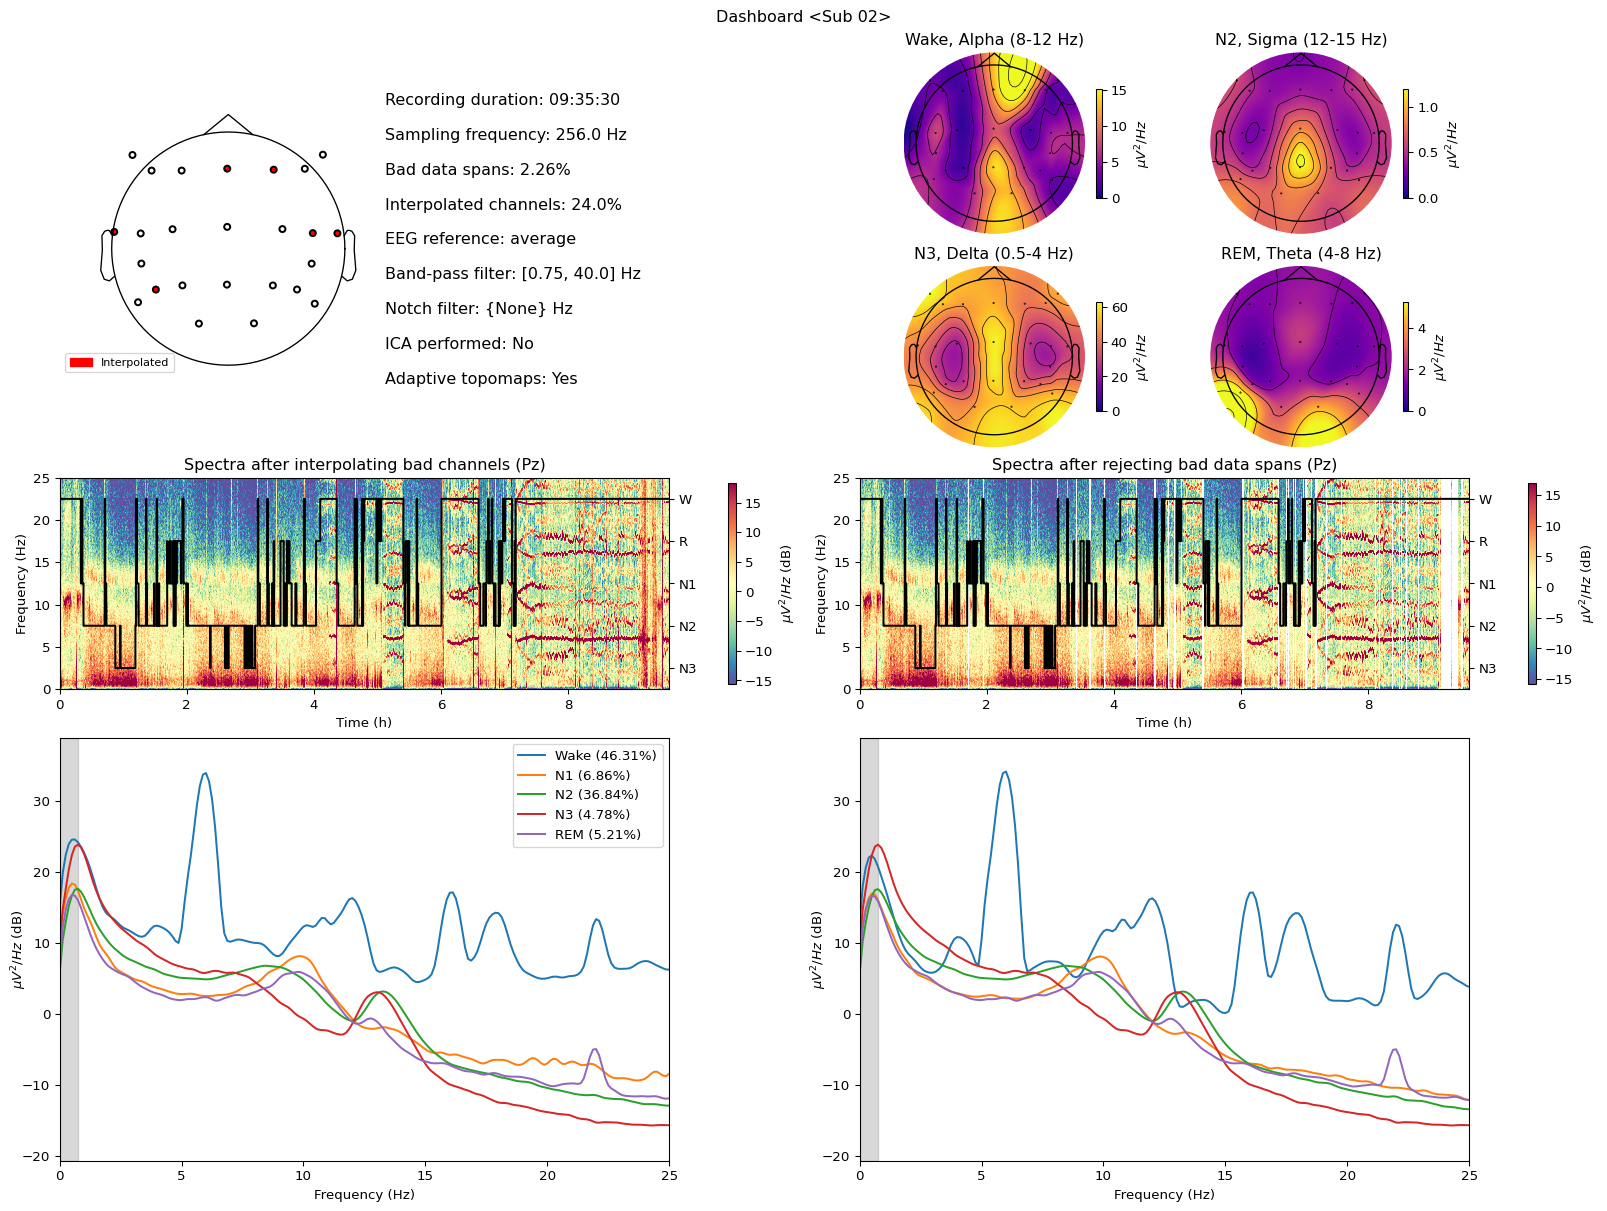

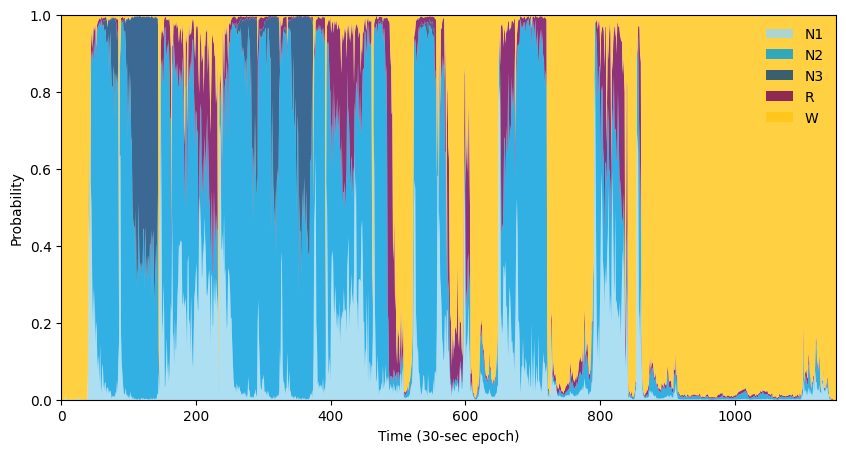

In [14]:
fig = create_dashboard(
    subject_code=subject_code,
    prec_pipe=pipe,
    hypno_psd_pick=picked_channel,
    hypnogram=hypnogram_path,
    predict_hypno_args=hypno_predict_arguments,
    hypno_freq=hypno_freq,
    reference="average",
)

## 2. Spectral

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Setting 200192 of 8839680 (2.26%) samples to NaN, retaining 8639488 (97.74%) samples.


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


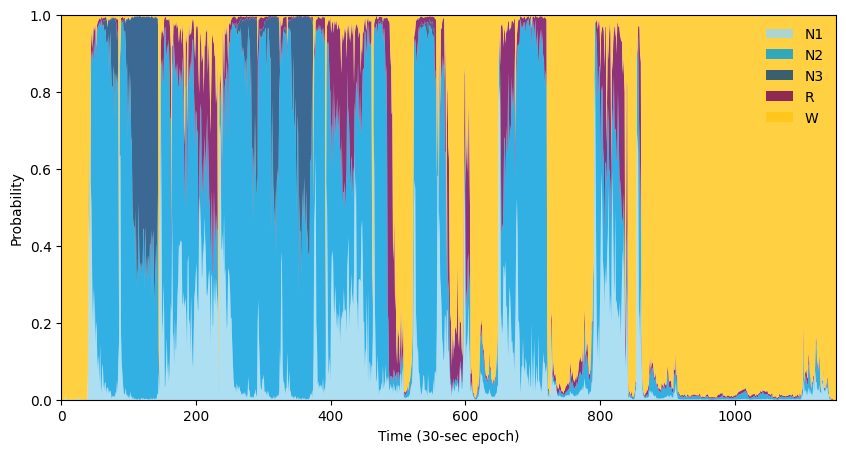

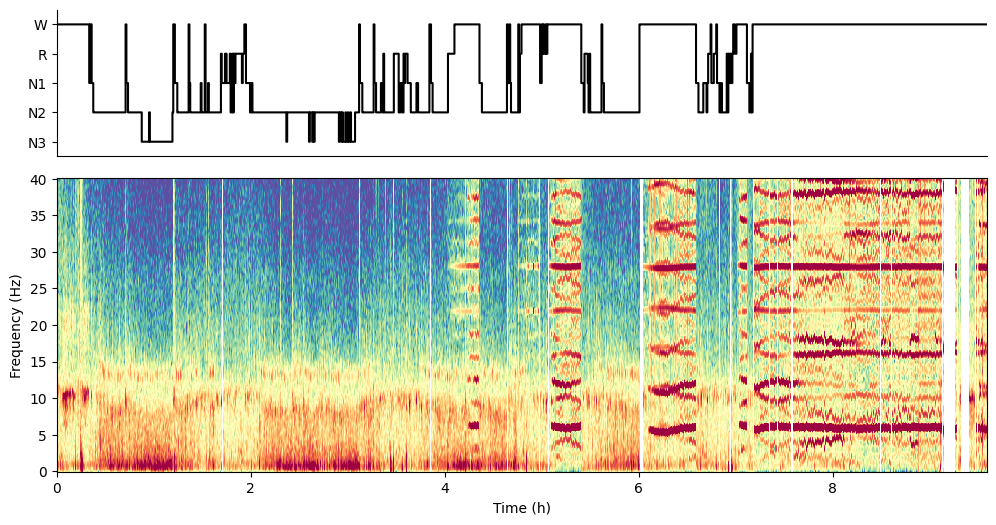

In [15]:
if hypnogram_path and hypnogram_path!="predict":
    spectral_pipe = SpectralPipe(prec_pipe=pipe,path_to_hypno=hypnogram_path,hypno_freq=hypno_freq)
else:
    spectral_pipe = SpectralPipe(prec_pipe=pipe)

if hypnogram_path is None or hypnogram_path=="predict":
    spectral_pipe.predict_hypno(
    eeg_name = hypno_predict_arguments["eeg_name"],
    eog_name = hypno_predict_arguments["eog_name"],
    emg_name =  hypno_predict_arguments["emg_name"],
    ref_name = hypno_predict_arguments["ref_name"],
    save=True)

spectral_pipe.plot_hypnospectrogram(picks=[picked_channel],save=True)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Setting 200192 of 8839680 (2.26%) samples to NaN, retaining 8639488 (97.74%) samples.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size

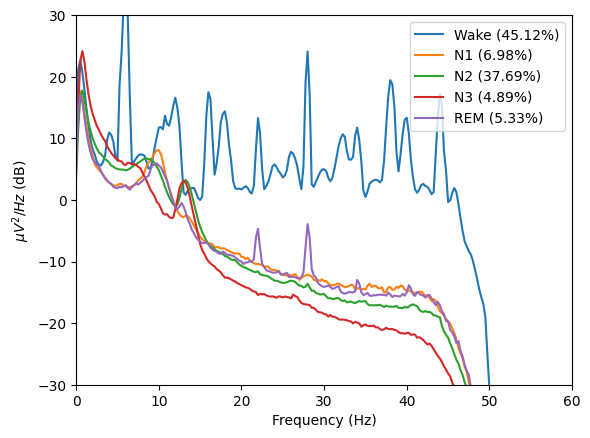

In [16]:
spectral_pipe.compute_psd(
    sleep_stages={"Wake": 0, "N1": 1, "N2": 2, "N3": 3, "REM": 4},
    reference="average",
    # Additional arguments passed to the Welch method:
    n_fft=1024,
    n_per_seg=1024,
    n_overlap=512,
    window="hamming",
    verbose=True,
    save=False,
)
spectral_pipe.plot_psds(picks=[picked_channel], psd_range=(-30, 30),save=True)

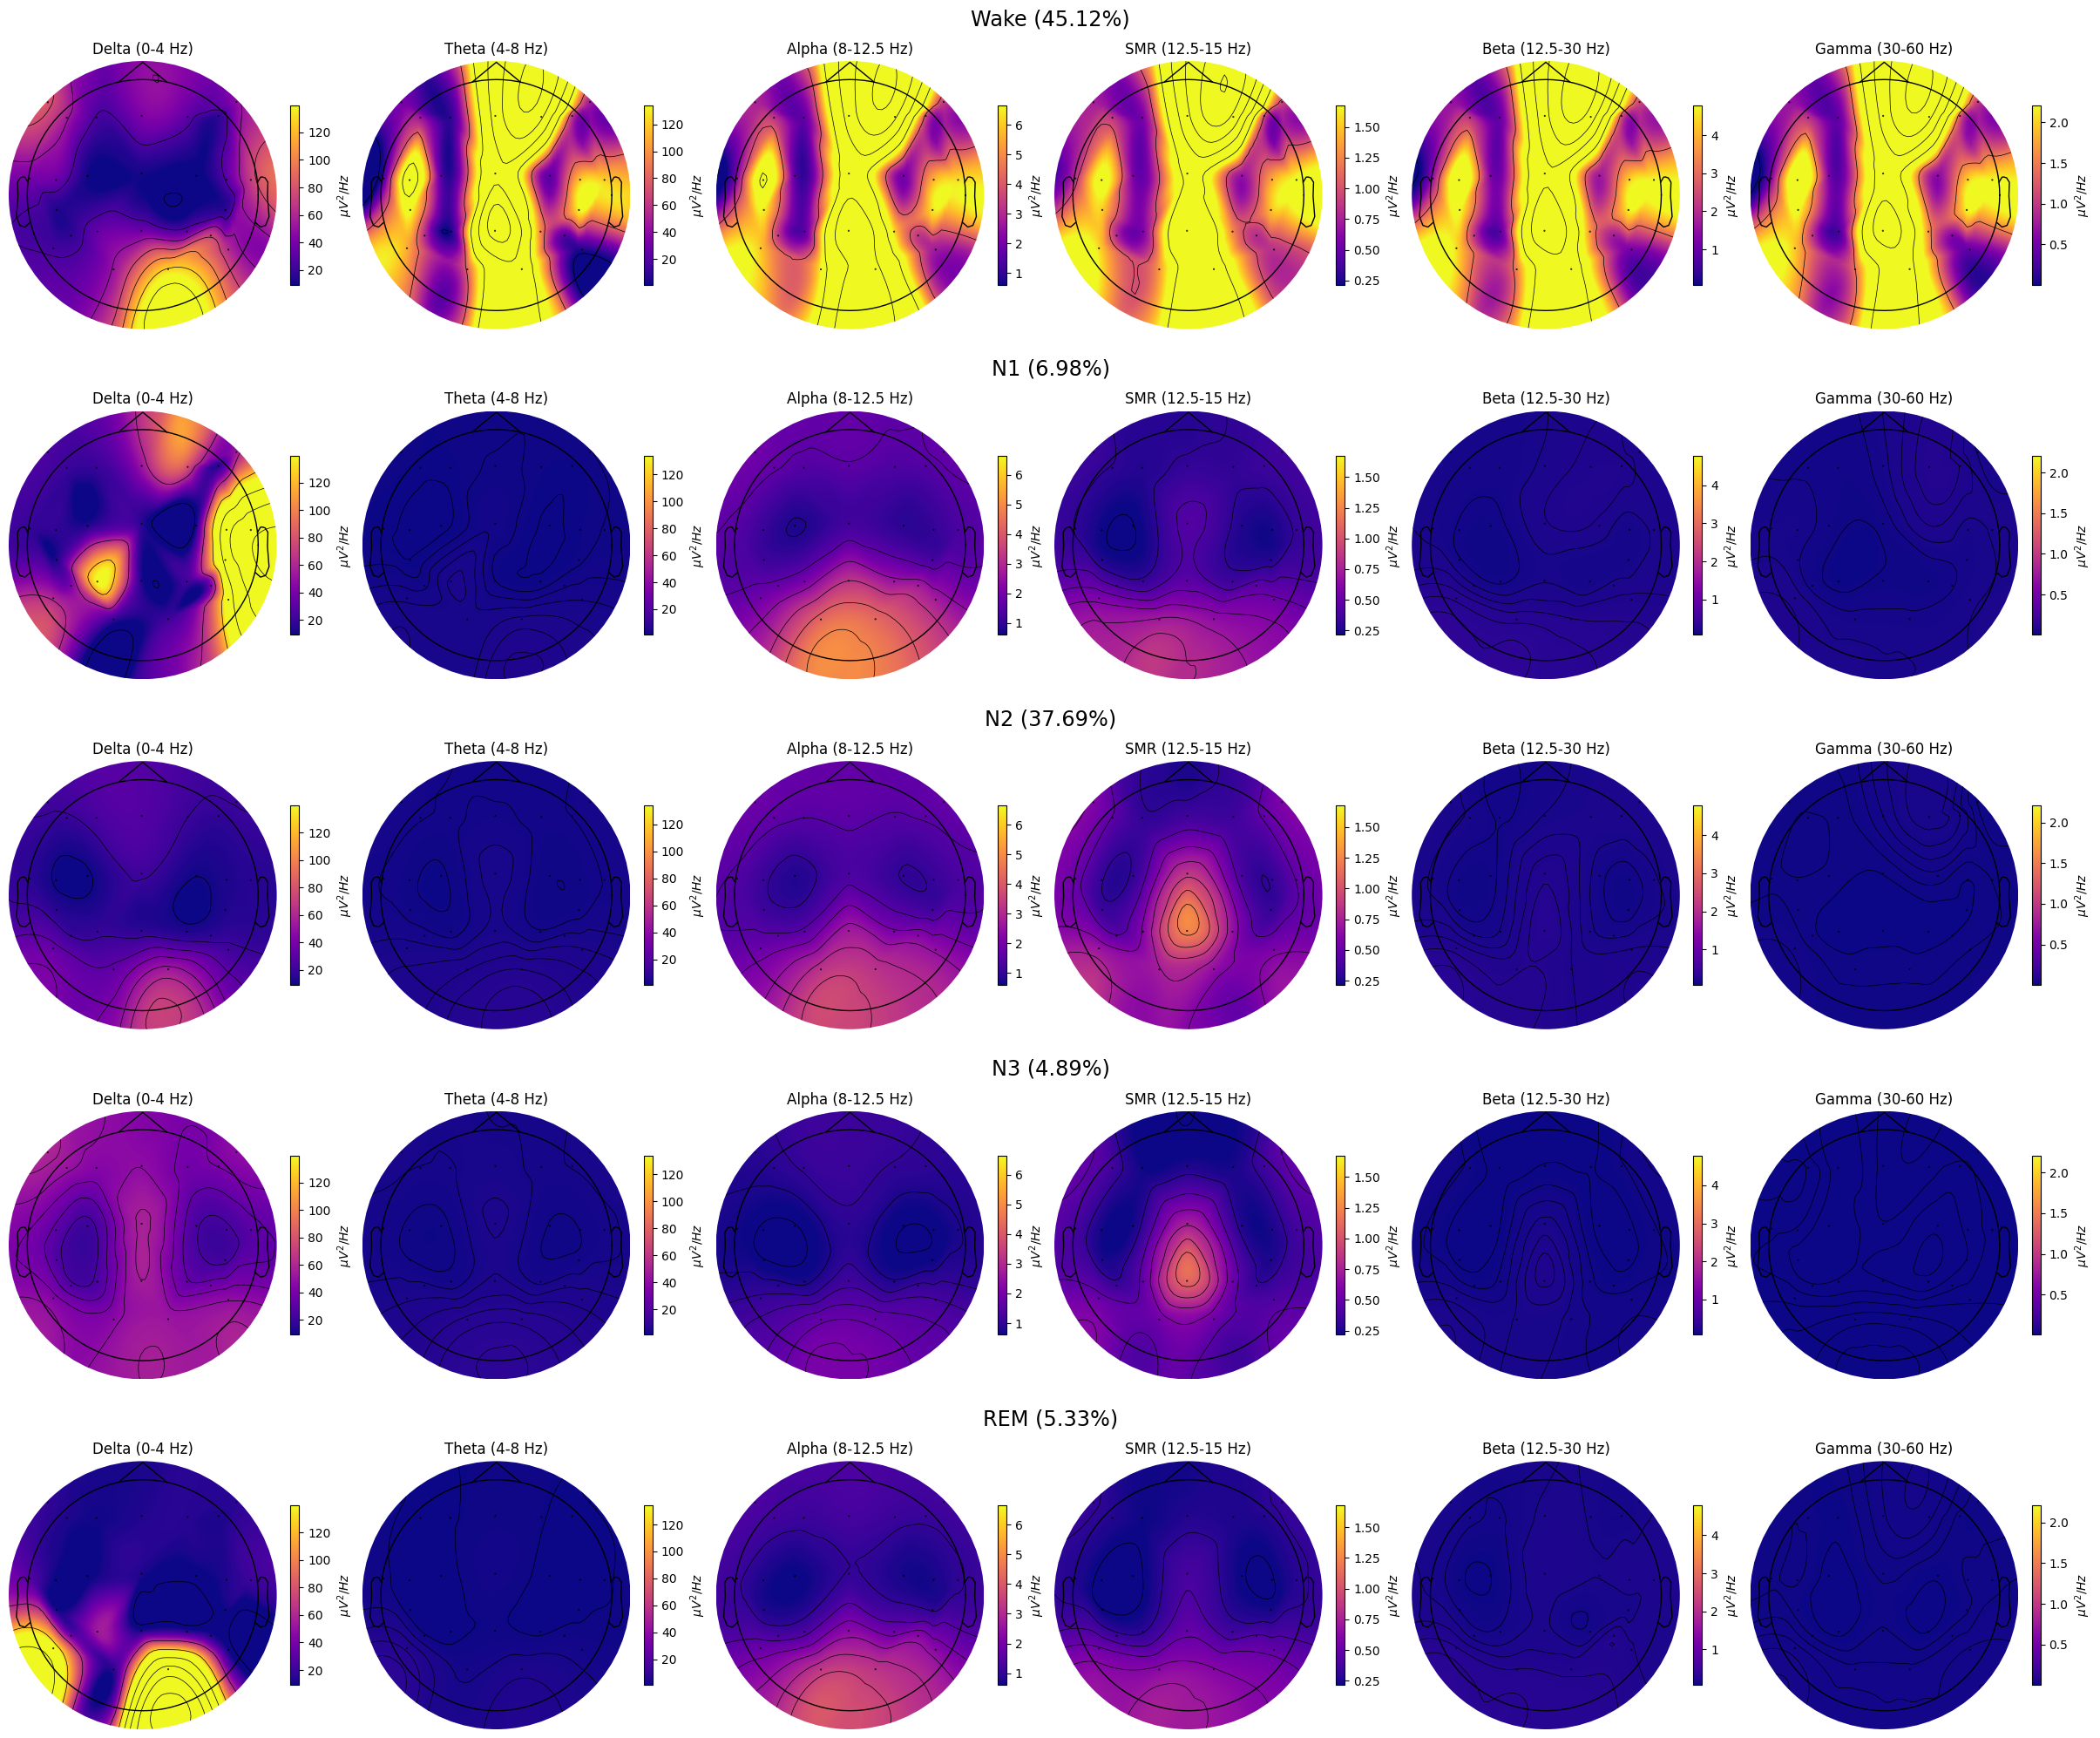

In [17]:
spectral_pipe.plot_topomap_collage(
    #  Bands to plot topomaps for.
    bands={
        "Delta": (0, 4),
        "Theta": (4, 8),
        "Alpha": (8, 12.5),
        "SMR": (12.5, 15),
        "Beta": (12.5, 30),
        "Gamma": (30, 60),
    },
    # Tuple of strs or "all", e.g., ("N1", "REM") or "all" (plots all "sleep_stages").
    stages_to_plot="all",
    dB=False,  # Whether to transform PSD to dB/Hz.
    low_percentile=5,  # Set min color value by percentile of the band data.
    high_percentile=95,  # Set max color value by percentile of the band data.
    fig=None,  # Instance of plt.Figure, a new fig will be created if None.
    save=True,  # Whether to save the plot as a file.
    topomap_args=dict(cmap="plasma"),  # Arguments passed to mne.viz.plot_topomap().
    cbar_args=None,  # Arguments passed to plt.colorbar().
)


Running FOOOFGroup across 25 power spectra.
Running FOOOFGroup across 25 power spectra.
Running FOOOFGroup across 25 power spectra.
Running FOOOFGroup across 25 power spectra.
Running FOOOFGroup across 25 power spectra.
Running FOOOFGroup across 25 power spectra.
                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                             Number of power spectra in the Group: 25                             
                                                                                                  
                        The model was run on the frequency range 0 - 60 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                           

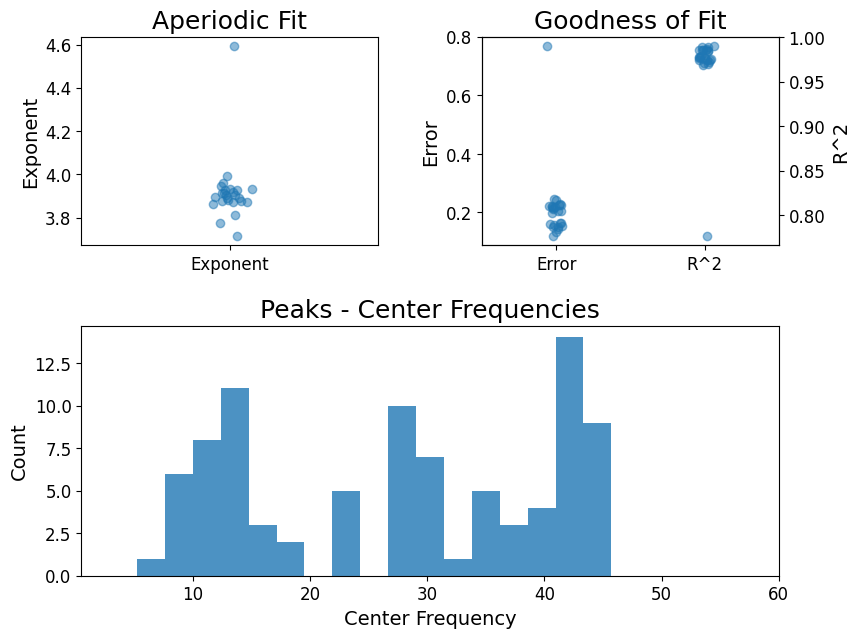

In [18]:
# Paramtrize spectrum
spectral_pipe.parametrize(
    picks=["eeg"],
    freq_range = [0.5, 60],
    average_ch=False,
)
spectral_pipe.fooofs["N2"].report()

In [19]:
spectral_pipe.sleep_stats(save=False) # in minutes

{'TIB': 575.5,
 'SPT': 410.5,
 'WASO': 101.5,
 'TST': 309.0,
 'N1': 39.5,
 'N2': 212.0,
 'N3': 27.5,
 'REM': 30.0,
 'NREM': 279.0,
 'SOL': 20.0,
 'Lat_N1': 20.0,
 'Lat_N2': 22.5,
 'Lat_N3': 52.5,
 'Lat_REM': 101.5,
 '%N1': 12.783171521035598,
 '%N2': 68.6084142394822,
 '%N3': 8.89967637540453,
 '%REM': 9.70873786407767,
 '%NREM': 90.29126213592232,
 'SE': 53.69244135534318,
 'SME': 75.27405602923264}

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 0 - 60 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -9.6568, 3.9207                                          
                                                                                                  
                                       4 peaks were found:                                        
          

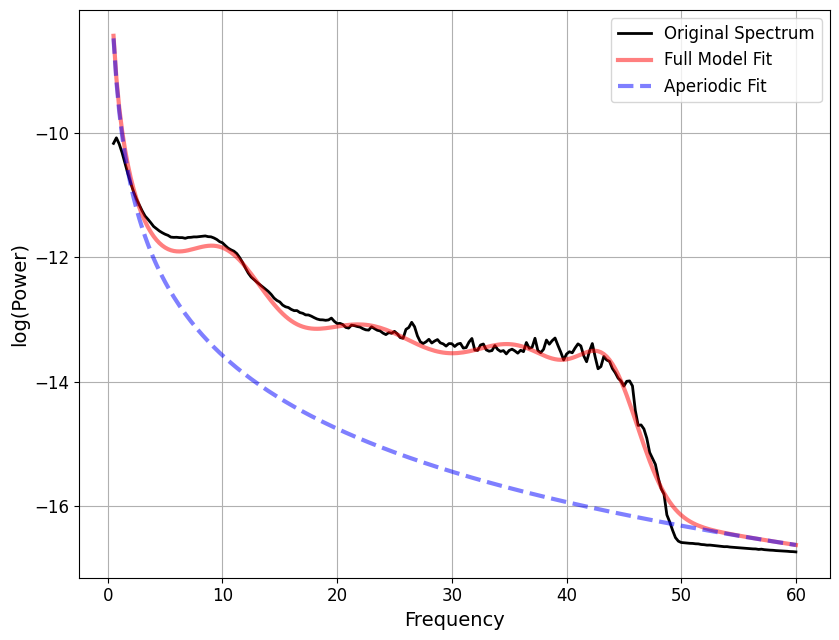

In [20]:
spectral_pipe.fooofs["N2"].get_fooof(ind=0).report()

In [21]:
from fooof.analysis import get_band_peak_fg

smr_peaks = get_band_peak_fg(spectral_pipe.fooofs["N2"], band=[12.5, 15]) # sigma band - includes sleep spindles and sensory-motor rhythm (smr)
smr_peaks #returns peaks
# centered frequency, power of the peak, bandwith

array([[        nan,         nan,         nan],
       [13.89422157,  1.83604244, 12.        ],
       [13.99020095,  2.02066402, 12.        ],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [13.84582257,  1.9856558 , 12.        ],
       [12.54404409,  1.82105439,  6.87346202],
       [14.37823201,  1.68079282,  8.82892788],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [12.55736138,  1.91048834, 10.65867486],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [12.66625374,  1.99106561, 10.99066267],
       [13.69564764,  1.91885337, 11.999

## 3. Events

### 3.1. Sleep spindles

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s


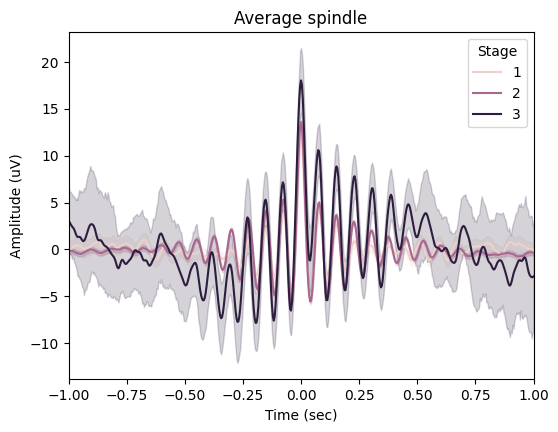

In [22]:
spindles_pipe = SpindlesPipe(prec_pipe=spectral_pipe)

spindles_pipe.detect()
spindles_pipe.plot_average(
    center="Peak",
    hue="Stage",
    time_before=1,
    time_after=1,
    save=True
)

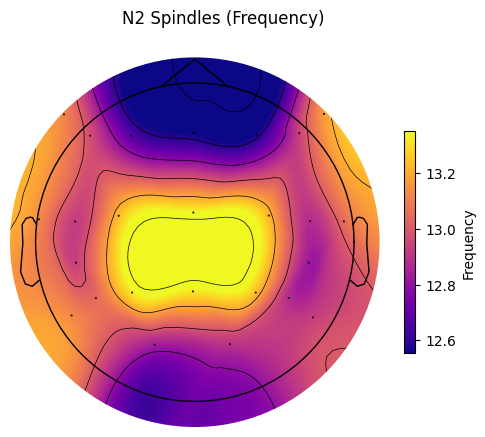

In [23]:
spindles_pipe.plot_topomap(
    prop="Frequency",  #  Any of the event properties returned by pipe.results.summary().
    stage="N2",  # Stage to plot the topomap for.
    aggfunc="mean",  # Aggregation function for channel grouping.
    # Should contain at least index of the provided "stage".
    sleep_stages={"Wake": 0, "N1": 1, "N2": 2, "N3": 3, "REM": 4},
    axis=None,  # Whether to plot on provided matplotlib axis.
    save=True,  # Whether to save the plot as a file.
    topomap_args=dict(cmap="plasma"),  # Arguments passed to mne.viz.plot_topomap().
    cbar_args=None,  # Arguments passed to plt.colorbar().
)

In [24]:
spindles_pipe.results.summary(grp_chan=False, grp_stage=True)

Count    Density  Duration  Amplitude       RMS  AbsPower  RelPower  \
Stage                                                                        
1        277   7.012658  0.834598  25.043944  5.322482  1.337815  0.333938   
2       2987  14.089623  0.774290  27.977693  6.096854  1.502691  0.355225   
3         26   0.945455  0.630709  33.788012  7.882147  1.753820  0.305594   

       Frequency  Oscillations  Symmetry  
Stage                                     
1      13.026507      9.916968  0.513534  
2      13.162950      9.540007  0.499835  
3      12.976957      7.923077  0.433743

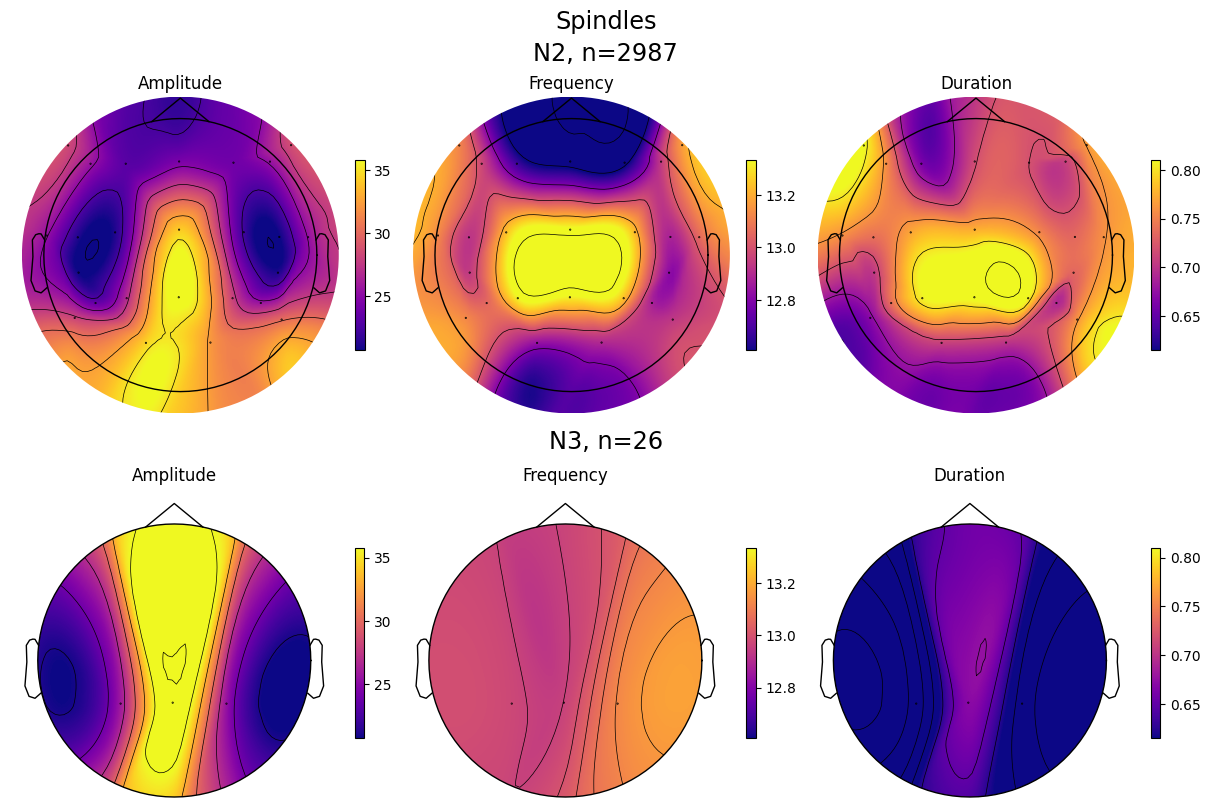

In [25]:
spindles_pipe.plot_topomap_collage(
    # Some of the event properties returned by pipe.results.summary().
    props=["Amplitude", "Frequency", "Duration"],
    aggfunc="mean",  # Aggregation function for channel grouping.
    # Tuple of strs or "all", e.g., ("N1", "REM") or "all" (plots all "sleep_stages").
    stages_to_plot="all",
    # Should contain at least indices of the provided "stages_to_plot".
    sleep_stages={"N2": 2, "N3": 3},
    low_percentile=5,  # Set min color value by percentile of the property data.
    high_percentile=95,  # Set max color value by percentile of the property data.
    fig=None,  # Instance of plt.Figure, a new fig will be created if None.
    save=True,  # Whether to save the plot as a file.
    topomap_args=dict(cmap="plasma"),  # Arguments passed to mne.viz.plot_topomap().
    cbar_args=None,  # Arguments passed to plt.colorbar().
)


In [27]:
spindles_pipe.compute_tfr(
    freqs=(10, 20),  # Interval of frequencies of interest.
    n_freqs=100,  # TFR frequency resolution.
    time_before=1,  # Time in sec before the peak to use in TFR computation. Should be positive.
    time_after=1,  # Time in sec after the peak to use in TFR computation.
    method="morlet",  # TFR method: 'morlet' or 'multitaper'.
    save=False,  # Whether to save AverageTFR object per sleep stage as hdf5 file.
    overwrite=False,  # Whether to overwrite existing files.
)

spindles_pipe.tfrs

100%|██████████| 3/3 [00:00<00:00, 40.22it/s]


{'N1': <AverageTFR | time : [-1.000000, 1.000000], freq : [10.000000, 20.000000], nave : 11, channels : 25, ~9.8 MB>,
 'N2': <AverageTFR | time : [-1.000000, 1.000000], freq : [10.000000, 20.000000], nave : 119, channels : 25, ~9.8 MB>,
 'N3': <AverageTFR | time : [-1.000000, 1.000000], freq : [10.000000, 20.000000], nave : 8, channels : 3, ~1.2 MB>}

In [28]:
spindles_pipe.tfrs["N2"].data

array([[[130.60956177, 135.51874683, 140.40751789, ..., 155.02614644,
         149.18439074, 143.34009358],
        [127.943433  , 132.77277875, 137.57932496, ..., 153.48181491,
         147.64391256, 141.80349348],
        [125.21518243, 129.9584746 , 134.67656697, ..., 151.82537233,
         145.9982554 , 140.16859483],
        ...,
        [ 23.97568556,  24.55853362,  24.97943477, ...,  21.74173421,
          21.39050926,  20.89018896],
        [ 23.73688978,  24.31090132,  24.7224832 , ...,  21.5110123 ,
          21.16437851,  20.66897975],
        [ 23.50115956,  24.0663085 ,  24.46853654, ...,  21.28648615,
          20.94414949,  20.45338255]],

       [[192.70259467, 200.30296121, 207.88945432, ..., 199.6851661 ,
         192.19326588, 184.701067  ],
        [187.50419528, 194.92289785, 202.32398617, ..., 195.81720005,
         188.42612502, 181.03275715],
        [182.32799671, 189.55884634, 196.76800415, ..., 191.89182228,
         184.60812338, 177.32008055],
        ...,


In [29]:
spindles_pipe.tfrs["N2"].to_data_frame()

time  freq          C3          C4          Cz         F10  \
0     -1.000000  10.0  130.609562  192.702595  255.153125  245.341488   
1     -0.996094  10.0  135.518747  200.302961  263.750746  253.532747   
2     -0.992188  10.0  140.407518  207.889454  272.205262  261.582377   
3     -0.988281  10.0  145.264544  215.443706  280.493615  269.468776   
4     -0.984375  10.0  150.078680  222.947513  288.593946  277.171426   
...         ...   ...         ...         ...         ...         ...   
51295  0.984375  20.0   21.531296   26.791871   71.779616   30.842704   
51296  0.988281  20.0   21.480582   26.809911   72.366499   30.049472   
51297  0.992188  20.0   21.286486   26.642980   72.444522   29.116451   
51298  0.996094  20.0   20.944149   26.285402   71.985752   28.048704   
51299  1.000000  20.0   20.453383   25.737030   70.977771   26.854752   

               F3          F4          F7          F8  ...          P7  \
0      138.207146  281.913104  257.560500  354.870188  ...  409.519278   
1      144.225614  292.532780  268.758464  368.410779  ...  426.579533   
2      150.280724  303.073422  279.998690  381.873509  ...  443.664946   
3      156.358192  313.506115  291.251669  395.223465  ...  460.732343   
4      162.443522  323.802428  302.487317  408.426378  ...  477.738144   
...           ...         ...         ...         ...  ...         ...   
51295   44.104659   38.199428   49.329196   41.910938  ...   49.167513   
51296   43.434528   38.176876   49.078149   42.062533  ...   48.643174   
51297   42.532302   37.919247   48.491725   41.921599  ...   47.848663   
51298   41.396505   37.412359   47.566326   41.473767  ...   46.777142   
51299   40.031973   36.650091   46.308175   40.714255  ...   45.429535   

               P8          P9          Pz         T10          T7          T8  \
0      326.242188  425.837242  422.783227  109.425521  208.269812  226.604827   
1      338.716746  444.156337  440.593428  113.623190  216.758630  234.392730   
2      351.178936  462.588031  458.464637  117.811388  225.275552  242.054140   
3      363.602213  481.093305  476.355839  121.981329  233.802751  249.566633   
4      375.960213  499.632691  494.225775  126.124486  242.322309  256.908729   
...           ...         ...         ...         ...         ...         ...   
51295   60.493254   52.176865   61.424852   26.240458   20.187338   32.597472   
51296   59.767602   52.157744   62.228431   25.888464   20.092365   32.639807   
51297   58.690960   51.827508   62.559850   25.365659   19.880078   32.469114   
51298   57.258889   51.165387   62.391144   24.676322   19.543534   32.074440   
51299   55.477798   50.160792   61.709228   23.829110   19.080057   31.451620   

               T9         TP7         TP8  
0      211.999692  135.785184  223.963982  
1      220.584802  140.322767  232.182993  
2      229.186561  144.824189  240.317250  
3      237.785876  149.283088  248.342931  
4      246.363564  153.693744  256.236624  
...           ...         ...         ...  
51295   28.470798   16.539407   24.649495  
51296   28.427718   16.341144   24.131394  
51297   28.215558   16.047965   23.503733  
51298   27.823693   15.659023   22.766391  
51299   27.247260   15.176224   21.922155  

[51300 rows x 27 columns]

No baseline correction applied


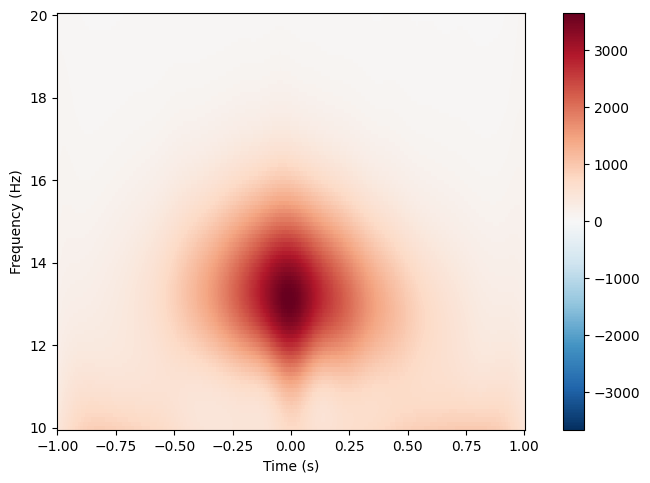

No baseline correction applied


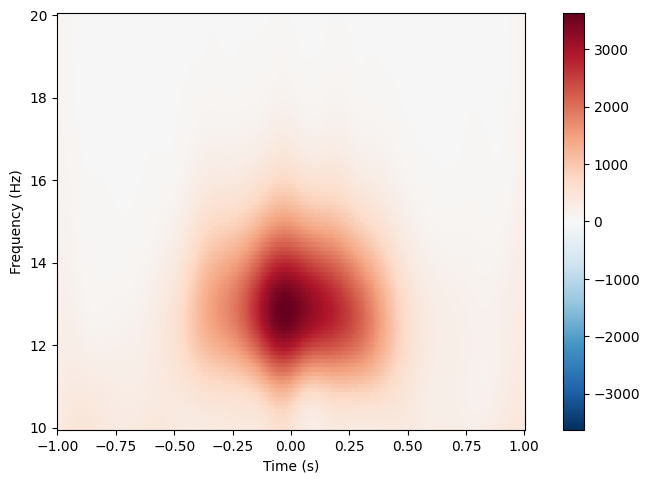

[<Figure size 640x480 with 2 Axes>]

In [30]:
spindles_pipe.tfrs["N2"].plot(["Pz"]),
spindles_pipe.tfrs["N3"].plot(["Pz"])

#### Picked channels results

In [31]:
spindles_pipe.detect(picks=['Pz', 'Cz', 'Fz'], include=(1,2,3))
spindles_pipe.results.summary().round(3)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Start       Peak        End  Duration  Amplitude     RMS  AbsPower  \
0     1217.332   1217.613   1217.910     0.578     21.978   5.390     1.556   
1     1225.688   1226.766   1226.844     1.156     38.465   7.428     1.633   
2     1293.457   1293.652   1294.125     0.668     26.841   5.975     1.626   
3     1367.070   1367.309   1367.770     0.699     26.483   6.744     1.663   
4     1443.285   1443.711   1444.492     1.207     53.656  12.549     2.437   
..         ...        ...        ...       ...        ...     ...       ...   
759  14007.422  14007.559  14008.449     1.027     23.109   4.686     1.314   
760  15874.457  15874.914  15875.242     0.785     22.172   4.562     1.202   
761  17014.902  17015.090  17015.473     0.570     19.715   4.871     1.315   
762  17179.188  17179.344  17179.875     0.688     23.551   5.126     1.335   
763  20754.660  20754.891  20755.191     0.531     17.944   4.281     1.336   

     RelPower  Frequency  Oscillations  Symmetry  Stage Channel  IdxChannel  
0       0.427     12.475           7.0     0.483      1      Pz           0  
1       0.404     12.881          14.0     0.929      1      Pz           0  
2       0.349     12.385           8.0     0.291      1      Pz           0  
3       0.430     13.673           9.0     0.339      2      Pz           0  
4       0.730     13.079          15.0     0.352      2      Pz           0  
..        ...        ...           ...       ...    ...     ...         ...  
759     0.366     12.571          13.0     0.133      2      Fz           2  
760     0.254     12.889           9.0     0.579      2      Fz           2  
761     0.303     12.392           6.0     0.327      2      Fz           2  
762     0.241     12.146           8.0     0.226      2      Fz           2  
763     0.449     12.768           6.0     0.431      2      Fz           2  

[764 rows x 14 columns]

In [32]:
spindles_pipe.results.summary(grp_chan=True, grp_stage=True, aggfunc='mean')

Count   Density  Duration  Amplitude       RMS  AbsPower  \
Stage Channel                                                             
1     Cz          11  0.278481  0.893821  29.247280  6.091045  1.449132   
      Fz           2  0.050633  0.783203  22.734220  4.910919  1.253655   
      Pz          27  0.683544  0.910735  31.078419  6.643065  1.612389   
2     Cz         163  0.768868  0.775043  34.141981  7.412386  1.696484   
      Fz          12  0.056604  0.717448  24.431012  5.331210  1.380442   
      Pz         533  2.514151  0.817645  36.540638  8.000521  1.802322   
3     Pz          16  0.581818  0.670410  38.668110  8.988995  1.858357   

               RelPower  Frequency  Oscillations  Symmetry  
Stage Channel                                               
1     Cz       0.358183  13.382855     10.545455  0.510456  
      Fz       0.280785  12.408474      8.500000  0.681964  
      Pz       0.402979  13.189003     11.000000  0.494082  
2     Cz       0.364073  13.350864      9.766871  0.496309  
      Fz       0.294497  12.553559      8.416667  0.477278  
      Pz       0.398193  13.326046     10.326454  0.485075  
3     Pz       0.312425  12.960933      8.312500  0.412424

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/yasa/detection.py:478: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_sync, x="Time", y="Amplitude", hue=hue, ax=ax, **kwargs)


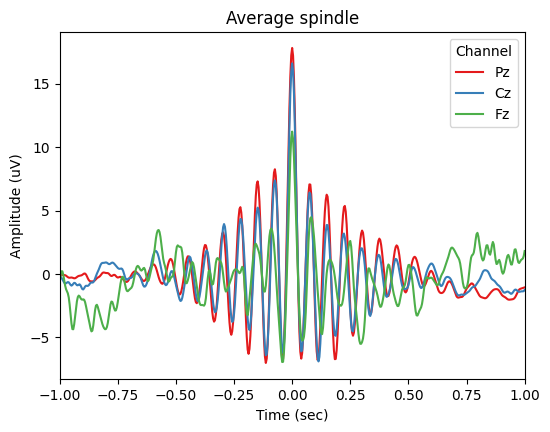

In [33]:
# Plot an average template per channel
spindles_pipe.plot_average(ci=None, palette="Set1")

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/yasa/detection.py:478: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_sync, x="Time", y="Amplitude", hue=hue, ax=ax, **kwargs)


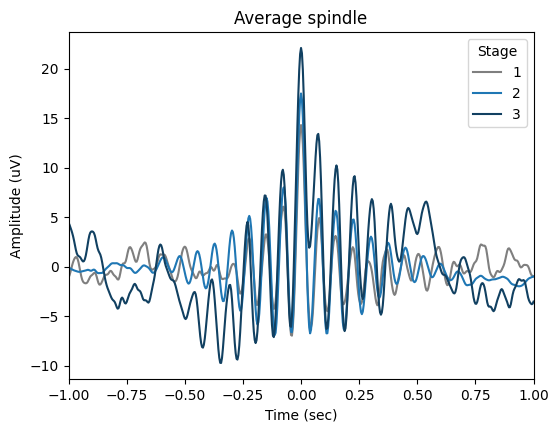

In [34]:
# Plot an average template per stage, using a custom color palette
spindles_pipe.plot_average(hue="Stage", ci=None, palette=['tab:grey', 'tab:blue', '#114061'])

In [35]:
spindles_pipe.results.compare_channels(score="recall", max_distance_sec=0.5).round(3)

Channel     Pz     Cz     Fz
Channel                     
Pz       1.000  0.252  0.016
Cz       0.833  1.000  0.040
Fz       0.643  0.500  1.000

In [36]:
spindles_pipe.results.compare_channels(max_distance_sec=0.5).round(3)

Channel     Pz     Cz     Fz
Channel                     
Pz       1.000  0.387  0.031
Cz       0.387  1.000  0.074
Fz       0.031  0.074  1.000

Finding spindles that are present on at least 2 channels

In [37]:
spindles_pipe.detect(picks=['Pz', 'Cz', 'Fz'], remove_outliers=True, multi_only=True)
spindles_pipe.results.summary().round(3)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Start       Peak        End  Duration  Amplitude     RMS  AbsPower  \
0     1225.688   1226.766   1226.844     1.156     38.465   7.428     1.633   
1     1547.793   1548.195   1548.383     0.590     43.144  10.174     1.991   
2     1629.020   1629.312   1630.148     1.129     41.528   9.428     1.987   
3     1732.199   1732.445   1732.863     0.664     42.203   9.484     2.076   
4     1737.988   1738.203   1739.020     1.031     43.626   9.504     1.942   
..         ...        ...        ...       ...        ...     ...       ...   
213   5659.102   5659.547   5659.863     0.762     24.617   5.409     1.347   
214   5823.418   5823.703   5824.133     0.715     26.750   5.490     1.514   
215   7662.246   7662.641   7662.879     0.633     25.304   5.885     1.461   
216  15874.457  15874.914  15875.242     0.785     22.172   4.562     1.202   
217  20754.660  20754.891  20755.191     0.531     17.944   4.281     1.336   

     RelPower  Frequency  Oscillations  Symmetry  Stage Channel  IdxChannel  
0       0.404     12.881          14.0     0.929      1      Pz           0  
1       0.460     13.162           8.0     0.678      2      Pz           0  
2       0.502     13.441          15.0     0.259      2      Pz           0  
3       0.402     13.959           8.0     0.368      2      Pz           0  
4       0.455     13.291          13.0     0.208      2      Pz           0  
..        ...        ...           ...       ...    ...     ...         ...  
213     0.240     12.133           9.0     0.582      2      Fz           2  
214     0.355     12.477           9.0     0.397      2      Fz           2  
215     0.267     12.170           8.0     0.620      2      Fz           2  
216     0.254     12.889           9.0     0.579      2      Fz           2  
217     0.449     12.768           6.0     0.431      2      Fz           2  

[218 rows x 14 columns]

In [38]:
spindles_pipe.results.summary(grp_chan=True)

Count  Duration  Amplitude       RMS  AbsPower  RelPower  Frequency  \
Channel                                                                        
Cz         104  0.740648  32.915543  7.174744  1.675881  0.361051  13.433299   
Fz           7  0.688616  24.591764  5.534038  1.452374  0.296457  12.429799   
Pz         107  0.901869  36.936646  7.987029  1.843534  0.467707  13.444716   

         Oscillations  Symmetry  
Channel                          
Cz           9.384615  0.494389  
Fz           8.142857  0.530385  
Pz          11.542056  0.509968

In [39]:
spindles_pipe.results.get_sync_events(center='Peak', time_before=0.8, time_after=0.8)

Time Event  Amplitude  Stage Channel  IdxChannel
0     -0.796875     0  -7.381018      1      Pz           0
1     -0.792969     0  -9.356663      1      Pz           0
2     -0.789062     0  -9.063256      1      Pz           0
3     -0.785156     0  -7.462823      1      Pz           0
4     -0.781250     0  -5.755758      1      Pz           0
...         ...   ...        ...    ...     ...         ...
89157  0.781250     6  -4.804699      2      Fz           2
89158  0.785156     6  -2.911162      2      Fz           2
89159  0.789062     6  -1.229692      2      Fz           2
89160  0.792969     6  -0.156077      2      Fz           2
89161  0.796875     6   0.275763      2      Fz           2

[89162 rows x 6 columns]

In [40]:
spindles_pipe.results.get_coincidence_matrix(scaled=False)

Channel     Pz     Cz    Fz
Channel                    
Pz       24811  17887   941
Cz       17887  19823   438
Fz         941    438  1241

In [41]:
coincidence = spindles_pipe.results.get_coincidence_matrix()
coincidence

Channel        Pz        Cz        Fz
Channel                              
Pz       1.000000  0.000036  0.000031
Cz       0.000036  1.000000  0.000018
Fz       0.000031  0.000018  1.000000

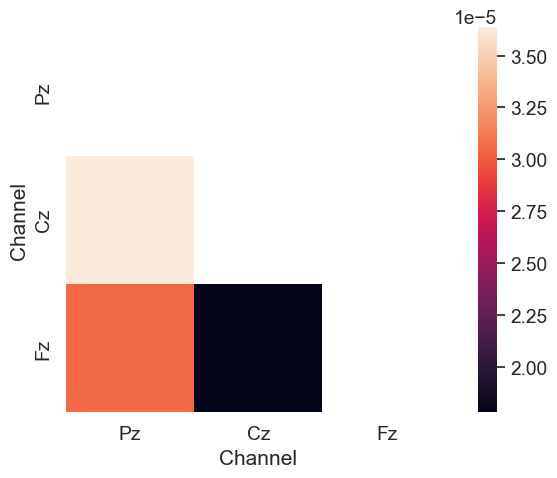

In [42]:
import seaborn as sns
sns.set(style="white", font_scale=1.25)


mask = np.zeros_like(coincidence)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(coincidence, mask=mask, square=True, cmap="rocket")


### 3.2. Slow waves

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s


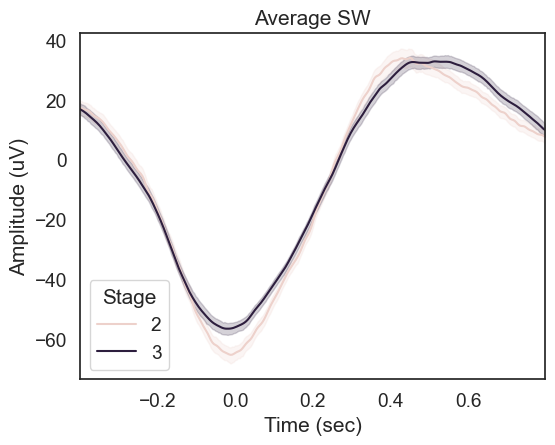

In [43]:
slow_waves_pipe = SlowWavesPipe(prec_pipe=spindles_pipe)
slow_waves_pipe.detect(
    picks=["eeg"],
    reference="average",
    include=(2, 3),
    freq_sw=(0.3, 1.5),
    dur_neg=(0.3, 1.5),
    dur_pos=(0.1, 1),
    amp_neg=(40, 200),
    amp_pos=(10, 150),
    amp_ptp=(75, 350),
    coupling=False,
    coupling_params={"freq_sp": (12, 16), "p": 0.05, "time": 1},
    remove_outliers=False,
    verbose=False,
    save=True,
)

slow_waves_pipe.plot_average(
    center="NegPeak",
    hue="Stage",
    time_before=0.4,
    time_after=0.8,
    save=True
)

In [44]:
slow_waves_pipe.results.summary(
    grp_chan=False, grp_stage=True, mask=None, aggfunc="mean", sort=True
)

Count   Density  Duration  ValNegPeak  ValPosPeak         PTP  \
Stage                                                                  
2        508  2.396226  1.238899  -57.351982   43.261806  100.613788   
3        223  8.109091  1.208257  -51.742695   40.047779   91.790475   

           Slope  Frequency  
Stage                        
2      372.43437    0.84904  
3      338.83395    0.84672

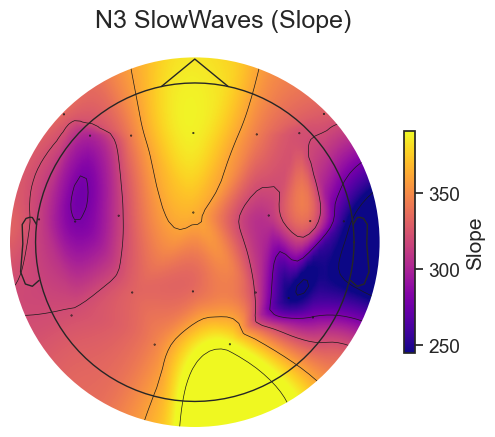

In [45]:
slow_waves_pipe.plot_topomap(
    prop="Slope",  #  Any of the event properties returned by pipe.results.summary().
    stage="N3",  # Stage to plot the topomap for.
    aggfunc="mean",  # Aggregation function for channel grouping.
    # Should contain at least index of the provided "stage".
    sleep_stages={"Wake": 0, "N1": 1, "N2": 2, "N3": 3, "REM": 4},
    axis=None,  # Whether to plot on provided matplotlib axis.
    save=True,  # Whether to save the plot as a file.
    topomap_args=dict(cmap="plasma"),  # Arguments passed to mne.viz.plot_topomap().
    cbar_args=None,  # Arguments passed to plt.colorbar().
)

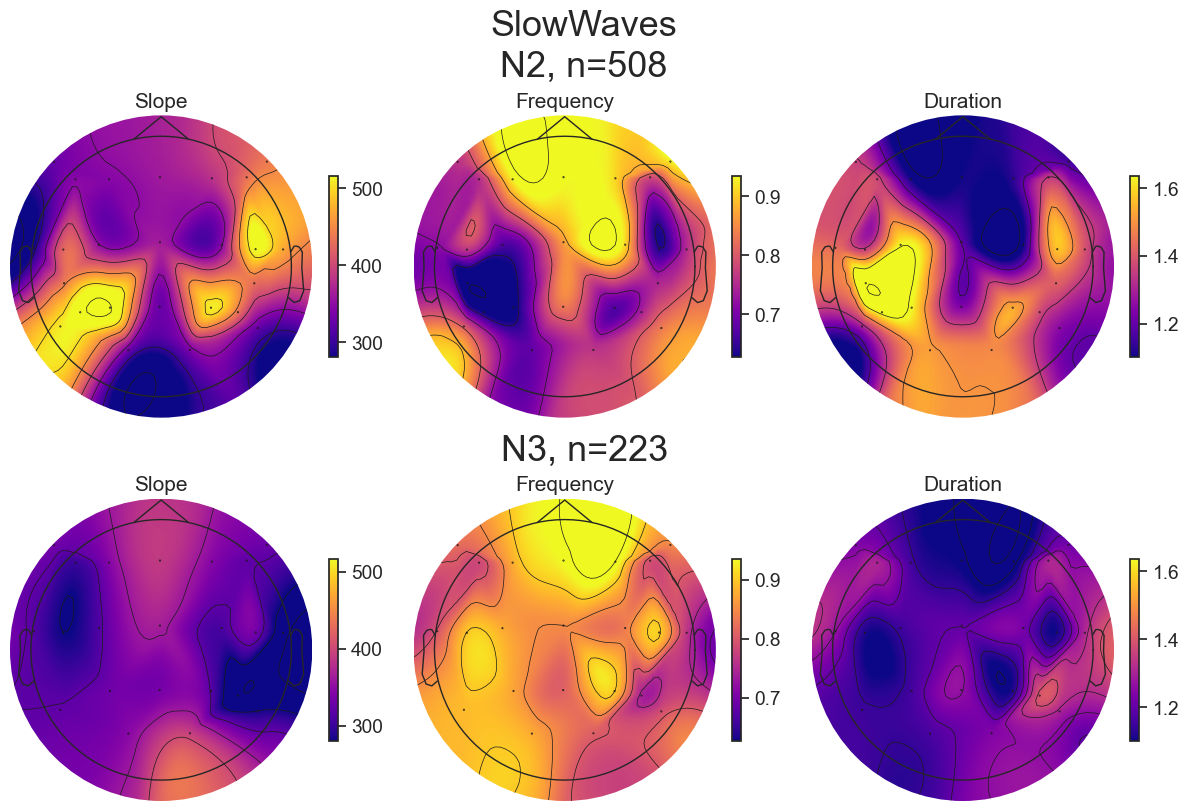

In [46]:
slow_waves_pipe.plot_topomap_collage(
    # Some of the event properties returned by pipe.results.summary().
    props=["Slope", "Frequency", "Duration"],
    aggfunc="mean",  # Aggregation function for channel grouping.
    # Tuple of strs or "all", e.g., ("N1", "REM") or "all" (plots all "sleep_stages").
    stages_to_plot="all",
    # Should contain at least indices of the provided "stages_to_plot".
    sleep_stages={"N2": 2, "N3": 3},
    low_percentile=5,  # Set min color value by percentile of the property data.
    high_percentile=95,  # Set max color value by percentile of the property data.
    fig=None,  # Instance of plt.Figure, a new fig will be created if None.
    save=True,  # Whether to save the plot as a file.
    topomap_args=dict(cmap="plasma"),  # Arguments passed to mne.viz.plot_topomap().
    cbar_args=None,  # Arguments passed to plt.colorbar().
)

In [47]:
slow_waves_pipe.compute_tfr(
    freqs=(0.5, 5), n_freqs=100, time_before=4, time_after=4, n_cycles=2,save=False
)
slow_waves_pipe.tfrs

100%|██████████| 22/22 [00:01<00:00, 16.74it/s]


{'N2': <AverageTFR | time : [-4.000000, 4.000000], freq : [0.500000, 5.000000], nave : 20, channels : 25, ~39.1 MB>,
 'N3': <AverageTFR | time : [-4.000000, 4.000000], freq : [0.500000, 5.000000], nave : 10, channels : 22, ~34.4 MB>}

In [48]:
slow_waves_pipe.tfrs["N2"].to_data_frame()

time  freq            C3           C4           Cz          F10  \
0      -4.000000   0.5  15972.953110  3308.976198  7731.119798  8260.799426   
1      -3.996094   0.5  16086.068202  3331.587395  7789.458419  8317.593624   
2      -3.992188   0.5  16199.218178  3354.207488  7847.868435  8374.378039   
3      -3.988281   0.5  16312.395678  3376.835051  7906.346286  8431.148320   
4      -3.984375   0.5  16425.593341  3399.468659  7964.888419  8487.900119   
...          ...   ...           ...          ...          ...          ...   
204895  3.984375   5.0    286.192401   111.626434  3913.708008  2144.429111   
204896  3.988281   5.0    262.434456    99.153625  3791.918634  2065.016831   
204897  3.992188   5.0    238.967144    87.710601  3651.994671  1977.759351   
204898  3.996094   5.0    216.123358    77.275213  3495.861797  1883.656512   
204899  4.000000   5.0    194.182998    67.813633  3325.749294  1783.832557   

                  F3            F4            F7            F8  ...  \
0        7424.591459   8015.814969   8059.983960  13220.013472  ...   
1        7479.139267   8072.911611   8117.851713  13314.764494  ...   
2        7533.668177   8130.025532   8175.704432  13409.494425  ...   
3        7588.172750   8187.152748   8233.537055  13504.195385  ...   
4        7642.647593   8244.289276   8291.344861  13598.859496  ...   
...              ...           ...           ...           ...  ...   
204895  22665.039197  29214.843797  20711.042418   2864.325511  ...   
204896  22050.698763  28390.085952  20219.956894   2746.238170  ...   
204897  21325.881375  27417.370417  19606.237757   2618.513263  ...   
204898  20500.767647  26308.430681  18881.105961   2482.737526  ...   
204899  19587.291292  25078.760018  18057.872694   2340.598145  ...   

                  P7           P8            P9           Pz          T10  \
0       34914.777494  3046.287760  14685.057635  8172.420680  3712.317437   
1       35126.247522  3066.931622  14845.969683  8237.109403  3743.435497   
2       35336.395261  3087.559331  15007.839148  8301.883856  3774.640353   
3       35545.173117  3108.169079  15170.659099  8366.738953  3805.930463   
4       35752.533240  3128.759102  15334.422374  8431.669594  3837.304255   
...              ...          ...           ...          ...          ...   
204895  14662.365189  1387.121157   1784.237005  1597.994852  1076.522112   
204896  14192.232484  1340.938429   1754.973514  1517.675319  1033.733508   
204897  13651.438268  1289.393131   1715.281288  1433.618476   989.169778   
204898  13048.235044  1232.941659   1665.634553  1346.815668   942.882515   
204899  12391.955214  1172.174032   1606.748613  1258.267655   894.997996   

                 T7           T8           T9         TP7         TP8  
0       2386.753086  2450.608181  3419.658223  650.776191  282.588097  
1       2406.530580  2466.955928  3447.162005  654.512382  283.949082  
2       2426.359638  2483.278043  3474.688552  658.256470  285.300743  
3       2446.238996  2499.573010  3502.235278  662.008771  286.642947  
4       2466.167401  2515.839323  3529.799603  665.769599  287.975557  
...             ...          ...          ...         ...         ...  
204895  7856.077532  1701.238381   867.639371  621.468076  305.317863  
204896  7495.771511  1592.374632   814.068695  592.323223  301.004916  
204897  7111.918622  1481.680153   760.935683  562.358366  295.135888  
204898  6709.625392  1370.565232   708.497612  531.723010  287.725910  
204899  6294.068549  1260.338876   657.008365  500.587822  278.830431  

[204900 rows x 27 columns]

No baseline correction applied


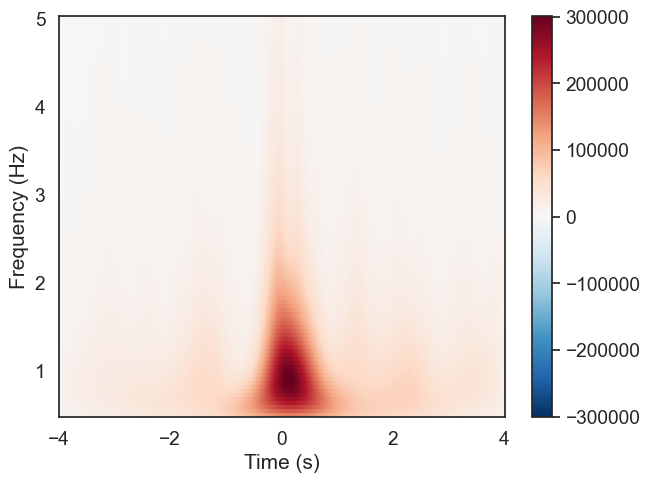

No baseline correction applied


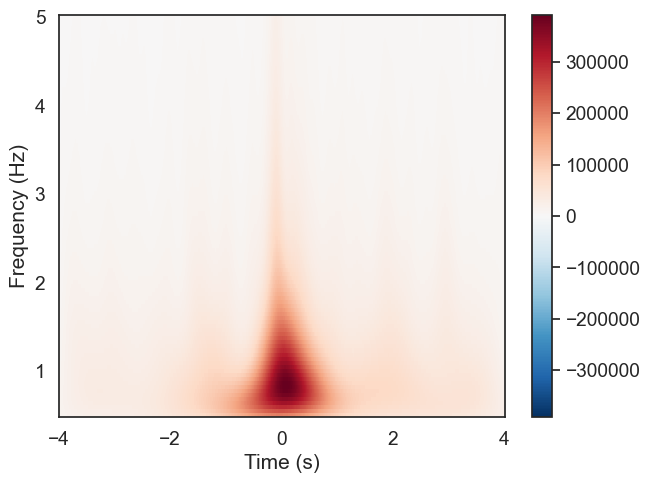

[<Figure size 640x480 with 2 Axes>]

In [49]:
slow_waves_pipe.tfrs["N2"].plot(["Cz"]),
slow_waves_pipe.tfrs["N3"].plot(["Cz"])